FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})
tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


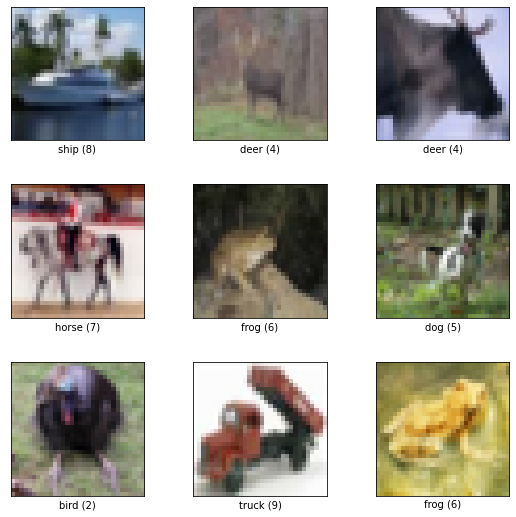

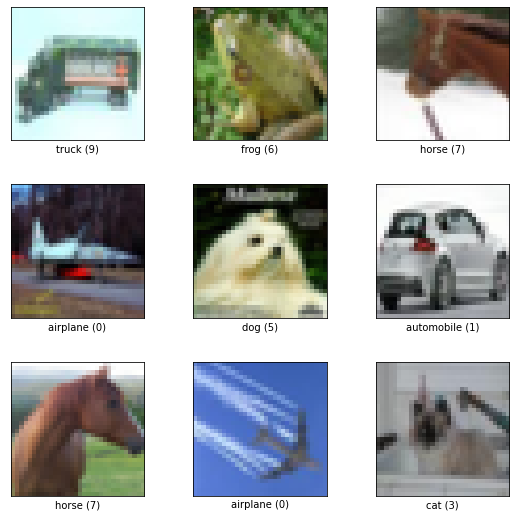

In [11]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

#데이터 획득
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)


# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요.
print(ds_info.features)
ds_info.features["label"].num_classes
ds_info.features["label"].names

# 데이터의 개수도 확인해 봅시다.
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

# Q. 이미지의 표현이 0과 1 사이로 들어오도록 직접 정규화 코드를 작성해봅시다.
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

#예시 이미지
fig = tfds.show_examples(ds_train, ds_info)
fig = tfds.show_examples(ds_test, ds_info)

# 데이터 정규화

BATCH_SIZE = 256
EPOCH = 15

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)



In [15]:
#블록 생성
def build_resnet_block(inputs,channel,is_50,is_plain,block_count):
  x = inputs
  for i in range(block_count):
    s = x # skip connection 지정
    if is_50 == False:
      if x.shape[-1] != channel:
        x = keras.layers.Conv2D(filters=channel,kernel_size=(3,3),strides=2,padding='same')(x)
        s = keras.layers.Conv2D(filters=channel,kernel_size=(1,1),strides=2,padding='same')(s) #스킵 커넥션 shape 같이 변경 
        s = keras.layers.BatchNormalization()(s)
      else:
        x = keras.layers.Conv2D(filters=channel,kernel_size=(3,3),padding='same')(x)
      x = keras.layers.BatchNormalization()(x)
      x = keras.layers.Activation('relu')(x)

      x = keras.layers.Conv2D(filters=channel,kernel_size=(3,3),padding='same')(x)
      x = keras.layers.BatchNormalization()(x)
      if is_plain == False:
        x = keras.layers.Add()([x, s]) # 합치기
      x = keras.layers.Activation('relu')(x)
    else:
      if x.shape[-1] != channel and x.shape[-1] != channel*4: #블록 시작할때 사이즈 줄이기
        x = keras.layers.Conv2D(filters=channel,kernel_size=(1,1),strides=2,padding='same')(x)
        s = keras.layers.Conv2D(filters=channel*4,kernel_size=(1,1),strides=2,padding='same')(s) #스킵 커넥션 shape 같이 변경 
        s = keras.layers.BatchNormalization()(s)
      else:
        x = keras.layers.Conv2D(filters=channel,kernel_size=(1,1),padding='same')(x)
      x = keras.layers.BatchNormalization()(x)
      x = keras.layers.Activation('relu')(x)

      x = keras.layers.Conv2D(filters=channel,kernel_size=(3,3),padding='same')(x)
      x = keras.layers.BatchNormalization()(x)
      x = keras.layers.Activation('relu')(x)

      x = keras.layers.Conv2D(filters=channel*4,kernel_size=(1,1),padding='same')(x)
      x = keras.layers.BatchNormalization()(x)

      if s.shape[-1] != x.shape[-1]: # 스킵커넥션 형태 안맞을때 형태 맞추기
        s = keras.layers.Conv2D(filters=channel*4,kernel_size=(1,1),padding='same')(s) #스킵 커넥션 shape 같이 변경 
        s = keras.layers.BatchNormalization()(s)

      if is_plain == False:
        x = keras.layers.Add()([x, s]) # 합치기
      x = keras.layers.Activation('relu')(x)
      

  return x

# resnet_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
# resnet_block_output = build_resnet_block(inputs=resnet_input_layer)    # VGG 블록 생성

# 블록 1개짜리 model 생성
# model = keras.Model(inputs=resnet_input_layer, outputs=resnet_block_output)
# model.summary()

# reset 모델 생성
def build_resnet(input_shape=(32,32,3),is_50=False,block_counts=[3,4,6,3],channels=[64,128,256,512]):
  inputs = keras.layers.Input(shape=input_shape)

  x = keras.layers.Conv2D(filters=channels[0],kernel_size=(7,7),strides=2,padding='same')(inputs)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Activation('relu')(x)
  x = keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2)(x)

  for (block_count,channel) in zip(block_counts,channels):
    if is_50 == False:
      x = build_resnet_block(x, channel,False,False,block_count)
    else:
      x = build_resnet_block(x, channel,True,False,block_count)

  x = keras.layers.Activation('relu')(x)
  x = keras.layers.AveragePooling2D(pool_size=(1,1))(x)
  x = keras.layers.Flatten()(x)
  outputs = keras.layers.Dense(10,activation='softmax')(x)

  model = keras.Model(inputs=inputs, outputs=outputs)

  return model

resnet_34 = build_resnet(input_shape=(32,32,3), is_50=False)
# resnet_34.summary()

resnet_50 = build_resnet(input_shape=(32,32,3), is_50=True)
# resnet_50.summary()

def build_plainnet(input_shape=(32,32,3),is_50=False,block_counts=[3,4,6,3],channels=[64,128,256,512]):
  inputs = keras.layers.Input(shape=input_shape)

  x = keras.layers.Conv2D(filters=channels[0],kernel_size=(7,7),strides=2,padding='same')(inputs)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Activation('relu')(x)
  x = keras.layers.MaxPooling2D(pool_size=(2, 2),strides=2)(x)

  for (block_count,channel) in zip(block_counts,channels):
    if is_50 == False:
      x = build_resnet_block(x, channel,False,True,block_count)
    else:
      x = build_resnet_block(x, channel,True,True,block_count)

  x = keras.layers.Activation('relu')(x)
  x = keras.layers.AveragePooling2D(pool_size=(1,1))(x)
  x = keras.layers.Flatten()(x)
  outputs = keras.layers.Dense(10,activation='softmax')(x)

  model = keras.Model(inputs=inputs, outputs=outputs)

  return model
  
plainnet_34 = build_plainnet(input_shape=(32,32,3), is_50=False)
# plainnet_34.summary()

plainnet_50 = build_plainnet(input_shape=(32,32,3), is_50=True)
# plainnet_50.summary()


In [22]:
#resnet_34,plainnet_34
BATCH_SIZE = 256
EPOCH = 15

resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_r_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

plainnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_p_34 = plainnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)



Epoch 1/15
195/195 [==============================] - 28s 98ms/step - loss: 1.2483 - accuracy: 0.5556 - val_loss: 1.6305 - val_accuracy: 0.4346
Epoch 2/15
195/195 [==============================] - 19s 97ms/step - loss: 1.1321 - accuracy: 0.5989 - val_loss: 1.5739 - val_accuracy: 0.4498
Epoch 3/15
195/195 [==============================] - 19s 95ms/step - loss: 0.9388 - accuracy: 0.6730 - val_loss: 1.5890 - val_accuracy: 0.4727
Epoch 4/15
195/195 [==============================] - 19s 95ms/step - loss: 0.7365 - accuracy: 0.7489 - val_loss: 1.7528 - val_accuracy: 0.4592
Epoch 5/15
195/195 [==============================] - 18s 94ms/step - loss: 0.5853 - accuracy: 0.8063 - val_loss: 1.9833 - val_accuracy: 0.4437
Epoch 6/15
195/195 [==============================] - 18s 95ms/step - loss: 0.4224 - accuracy: 0.8675 - val_loss: 1.9917 - val_accuracy: 0.4567
Epoch 7/15
195/195 [==============================] - 19s 95ms/step - loss: 0.2884 - accuracy: 0.9101 - val_loss: 2.2704 - val_accuracy:

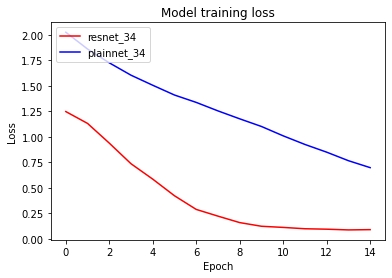

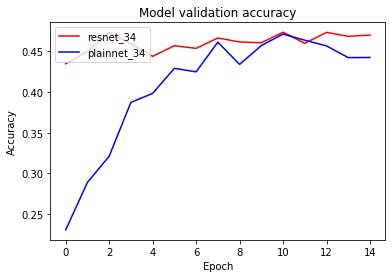

In [25]:
plt.plot(history_r_34.history['loss'], 'r')
plt.plot(history_p_34.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plainnet_34'], loc='upper left')
plt.show()

plt.plot(history_r_34.history['val_accuracy'], 'r')
plt.plot(history_p_34.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plainnet_34'], loc='upper left')
plt.show()

In [23]:
#resnet_50,plainnet_50
BATCH_SIZE = 256
EPOCH = 15

resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_r_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

plainnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_p_50 = plainnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
195/195 [==============================] - 35s 123ms/step - loss: 2.2856 - accuracy: 0.2018 - val_loss: 2.4308 - val_accuracy: 0.1834
Epoch 2/15
195/195 [==============================] - 24s 121ms/step - loss: 2.1686 - accuracy: 0.2286 - val_loss: 4.0538 - val_accuracy: 0.1576
Epoch 3/15
195/195 [==============================] - 23s 119ms/step - loss: 2.0833 - accuracy: 0.2544 - val_loss: 2.3615 - val_accuracy: 0.2161
Epoch 4/15
195/195 [==============================] - 23s 119ms/step - loss: 1.9594 - accuracy: 0.2949 - val_loss: 2.3902 - val_accuracy: 0.2617
Epoch 5/15
195/195 [==============================] - 23s 119ms/step - loss: 1.8511 - accuracy: 0.3371 - val_loss: 2.1414 - val_accuracy: 0.3047
Epoch 6/15
195/195 [==============================] - 23s 120ms/step - loss: 1.7700 - accuracy: 0.3598 - val_loss: 2.1345 - val_accuracy: 0.3068
Epoch 7/15
195/195 [==============================] - 23s 119ms/step - loss: 1.6638 - accuracy: 0.3998 - val_loss: 1.8755 - val_ac

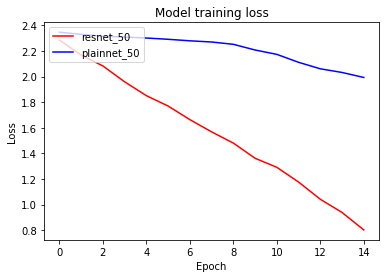

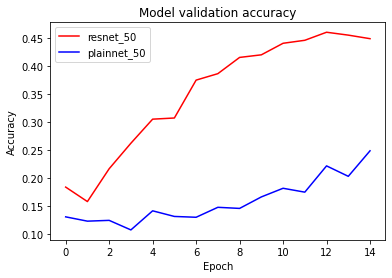

In [24]:
plt.plot(history_r_50.history['loss'], 'r')
plt.plot(history_p_50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plainnet_50'], loc='upper left')
plt.show()

plt.plot(history_r_50.history['val_accuracy'], 'r')
plt.plot(history_p_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plainnet_50'], loc='upper left')
plt.show()